In [1]:
### imports

import keras
import numpy as np
import pandas as pd
from scipy import stats
from keras.models import Model
from keras.layers import Input, Dense
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import uproot
import awkward as ak
from tqdm.notebook import tqdm

In [2]:
# latex settings block

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.numpoints": 1,
    "axes.linewidth": 2,
    "legend.title_fontsize": 18,
    "axes.labelsize": 18,
    "legend.fontsize": 16
})

In [3]:
with np.load("root_files/subjettiness_and_impact_parameter_train.npz") as file:
    feature_array = file['features']
    label_array = file['labels']
    features = file['names'].tolist()
    
nfeatures = len(features)
nlabels = 2

In [4]:
df = pd.DataFrame(feature_array, columns=features)
bkg = df[label_array[:,0]==1]
sig = df[label_array[:,1]==1]

In [6]:
del feature_array, label_array

In [7]:
with np.load("root_files/subjettiness_and_impact_parameter_test.npz") as file:
    feature_array_test = file['features']
    label_array_test = file['labels']

In [8]:
df_test = pd.DataFrame(feature_array_test, columns=features)
bkg_test = df_test[label_array_test[:,0]==1]
sig_test = df_test[label_array_test[:,1]==1]

In [9]:
del feature_array_test, label_array_test

In [10]:
sig_train_out = sig
bkg_train_out = bkg
sig_test_out = sig_test
bkg_test_out = bkg_test

In [11]:
print(bkg.shape)
print(bkg_train_out.shape)
print(bkg_test.shape)
print(bkg_test_out.shape)

(11734326, 31)
(11734326, 31)
(1467277, 31)
(1467277, 31)


In [12]:
del bkg, sig, bkg_test, sig_test, df

In [13]:
bkg_train_out = bkg_train_out.sample(len(sig_train_out)).reset_index(drop=True)
bkg_test_out = bkg_test_out.sample(len(sig_test_out)).reset_index(drop=True)

In [14]:
print(bkg_train_out.shape)
print(sig_train_out.shape)
print(bkg_test_out.shape)
print(sig_test_out.shape)

(1782913, 31)
(1782913, 31)
(222732, 31)
(222732, 31)


  0%|          | 0/30 [00:00<?, ?it/s]

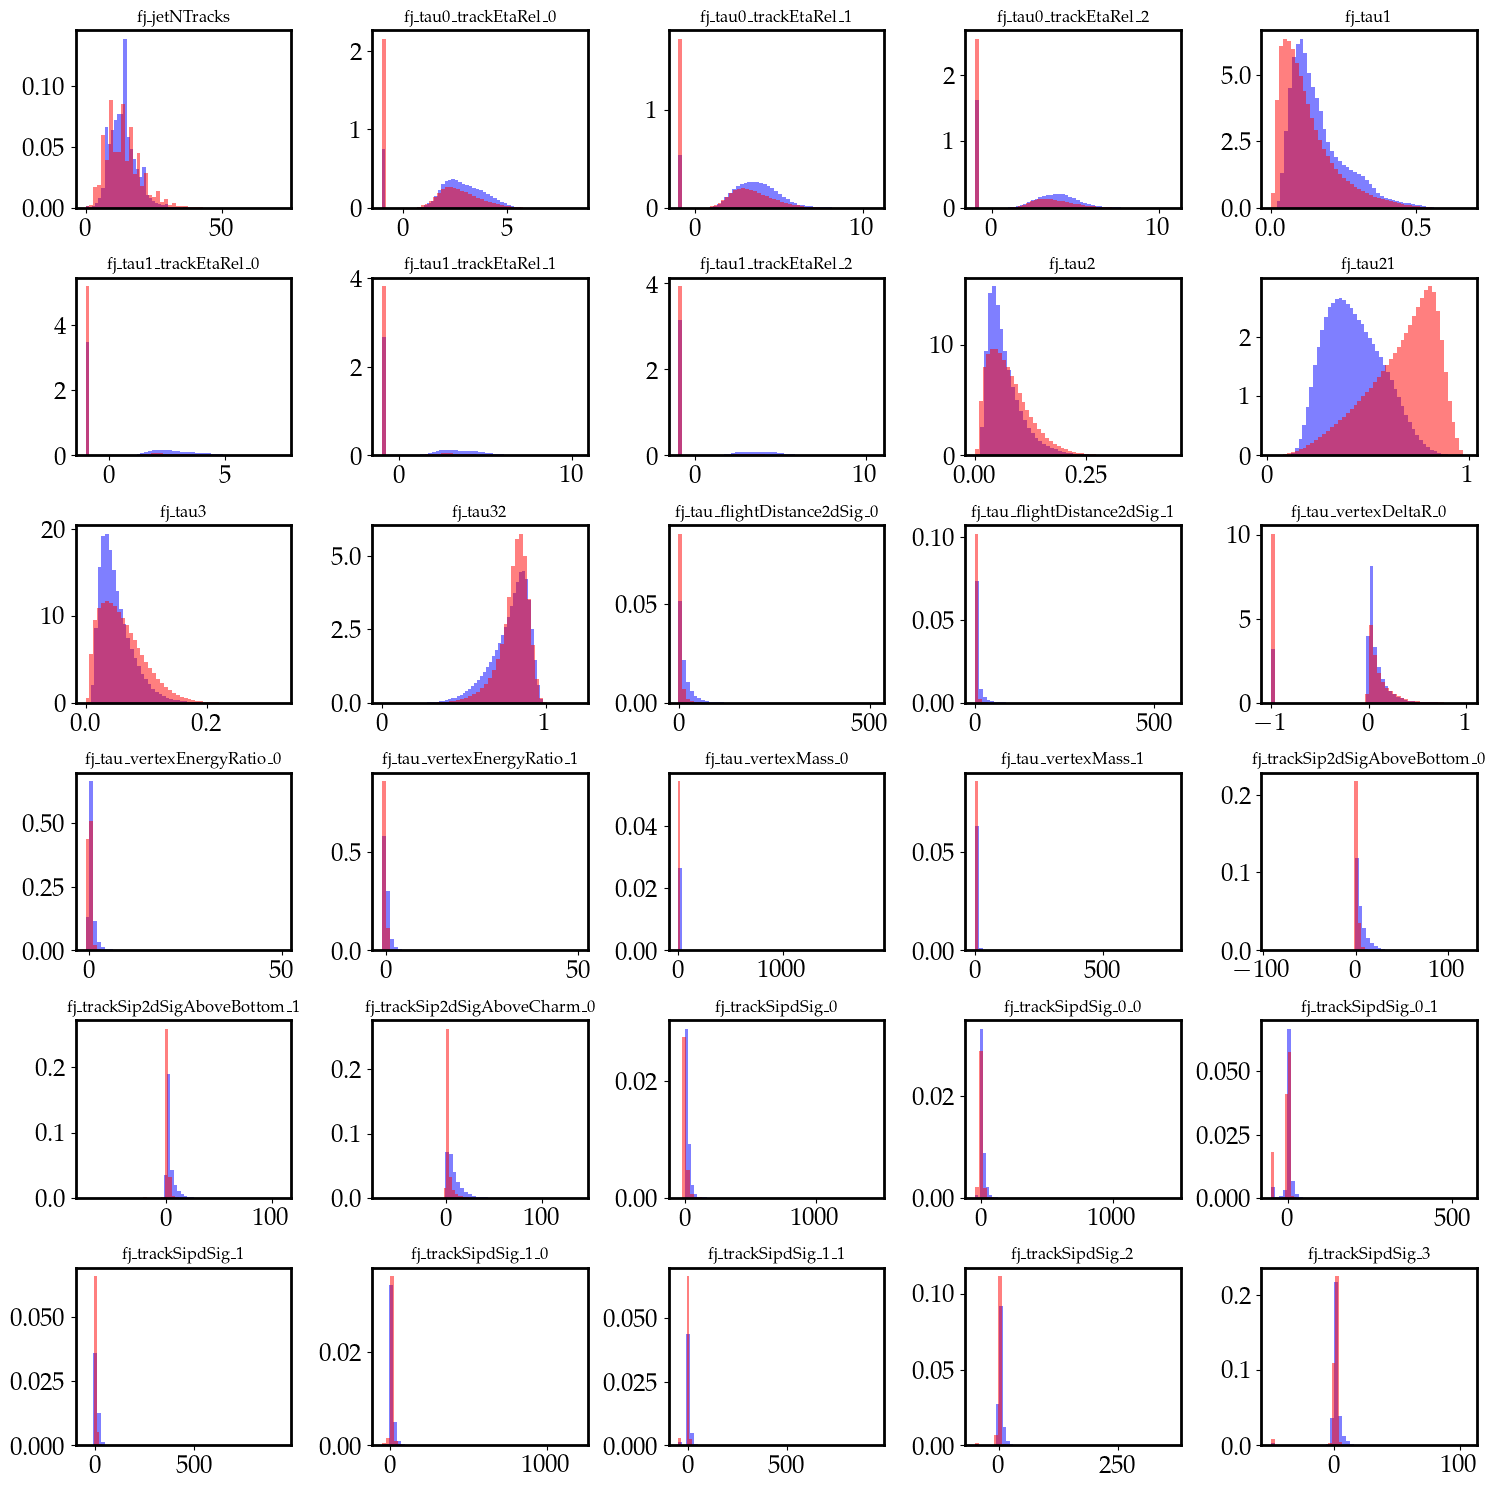

In [16]:
fig, axes = plt.subplots(6,5, figsize=(15,15))

for ax, label in tqdm(zip(axes.ravel(), sig_train_out.columns.drop('fj_nSV')), total = 30):
    ax.hist(sig_train_out[label],density=True,color='b',alpha=0.5,bins=50)
    ax.hist(bkg_train_out[label],density=True,color='r',alpha=0.5,bins=50)
    ax.set_title(label)

plt.tight_layout()
plt.show()

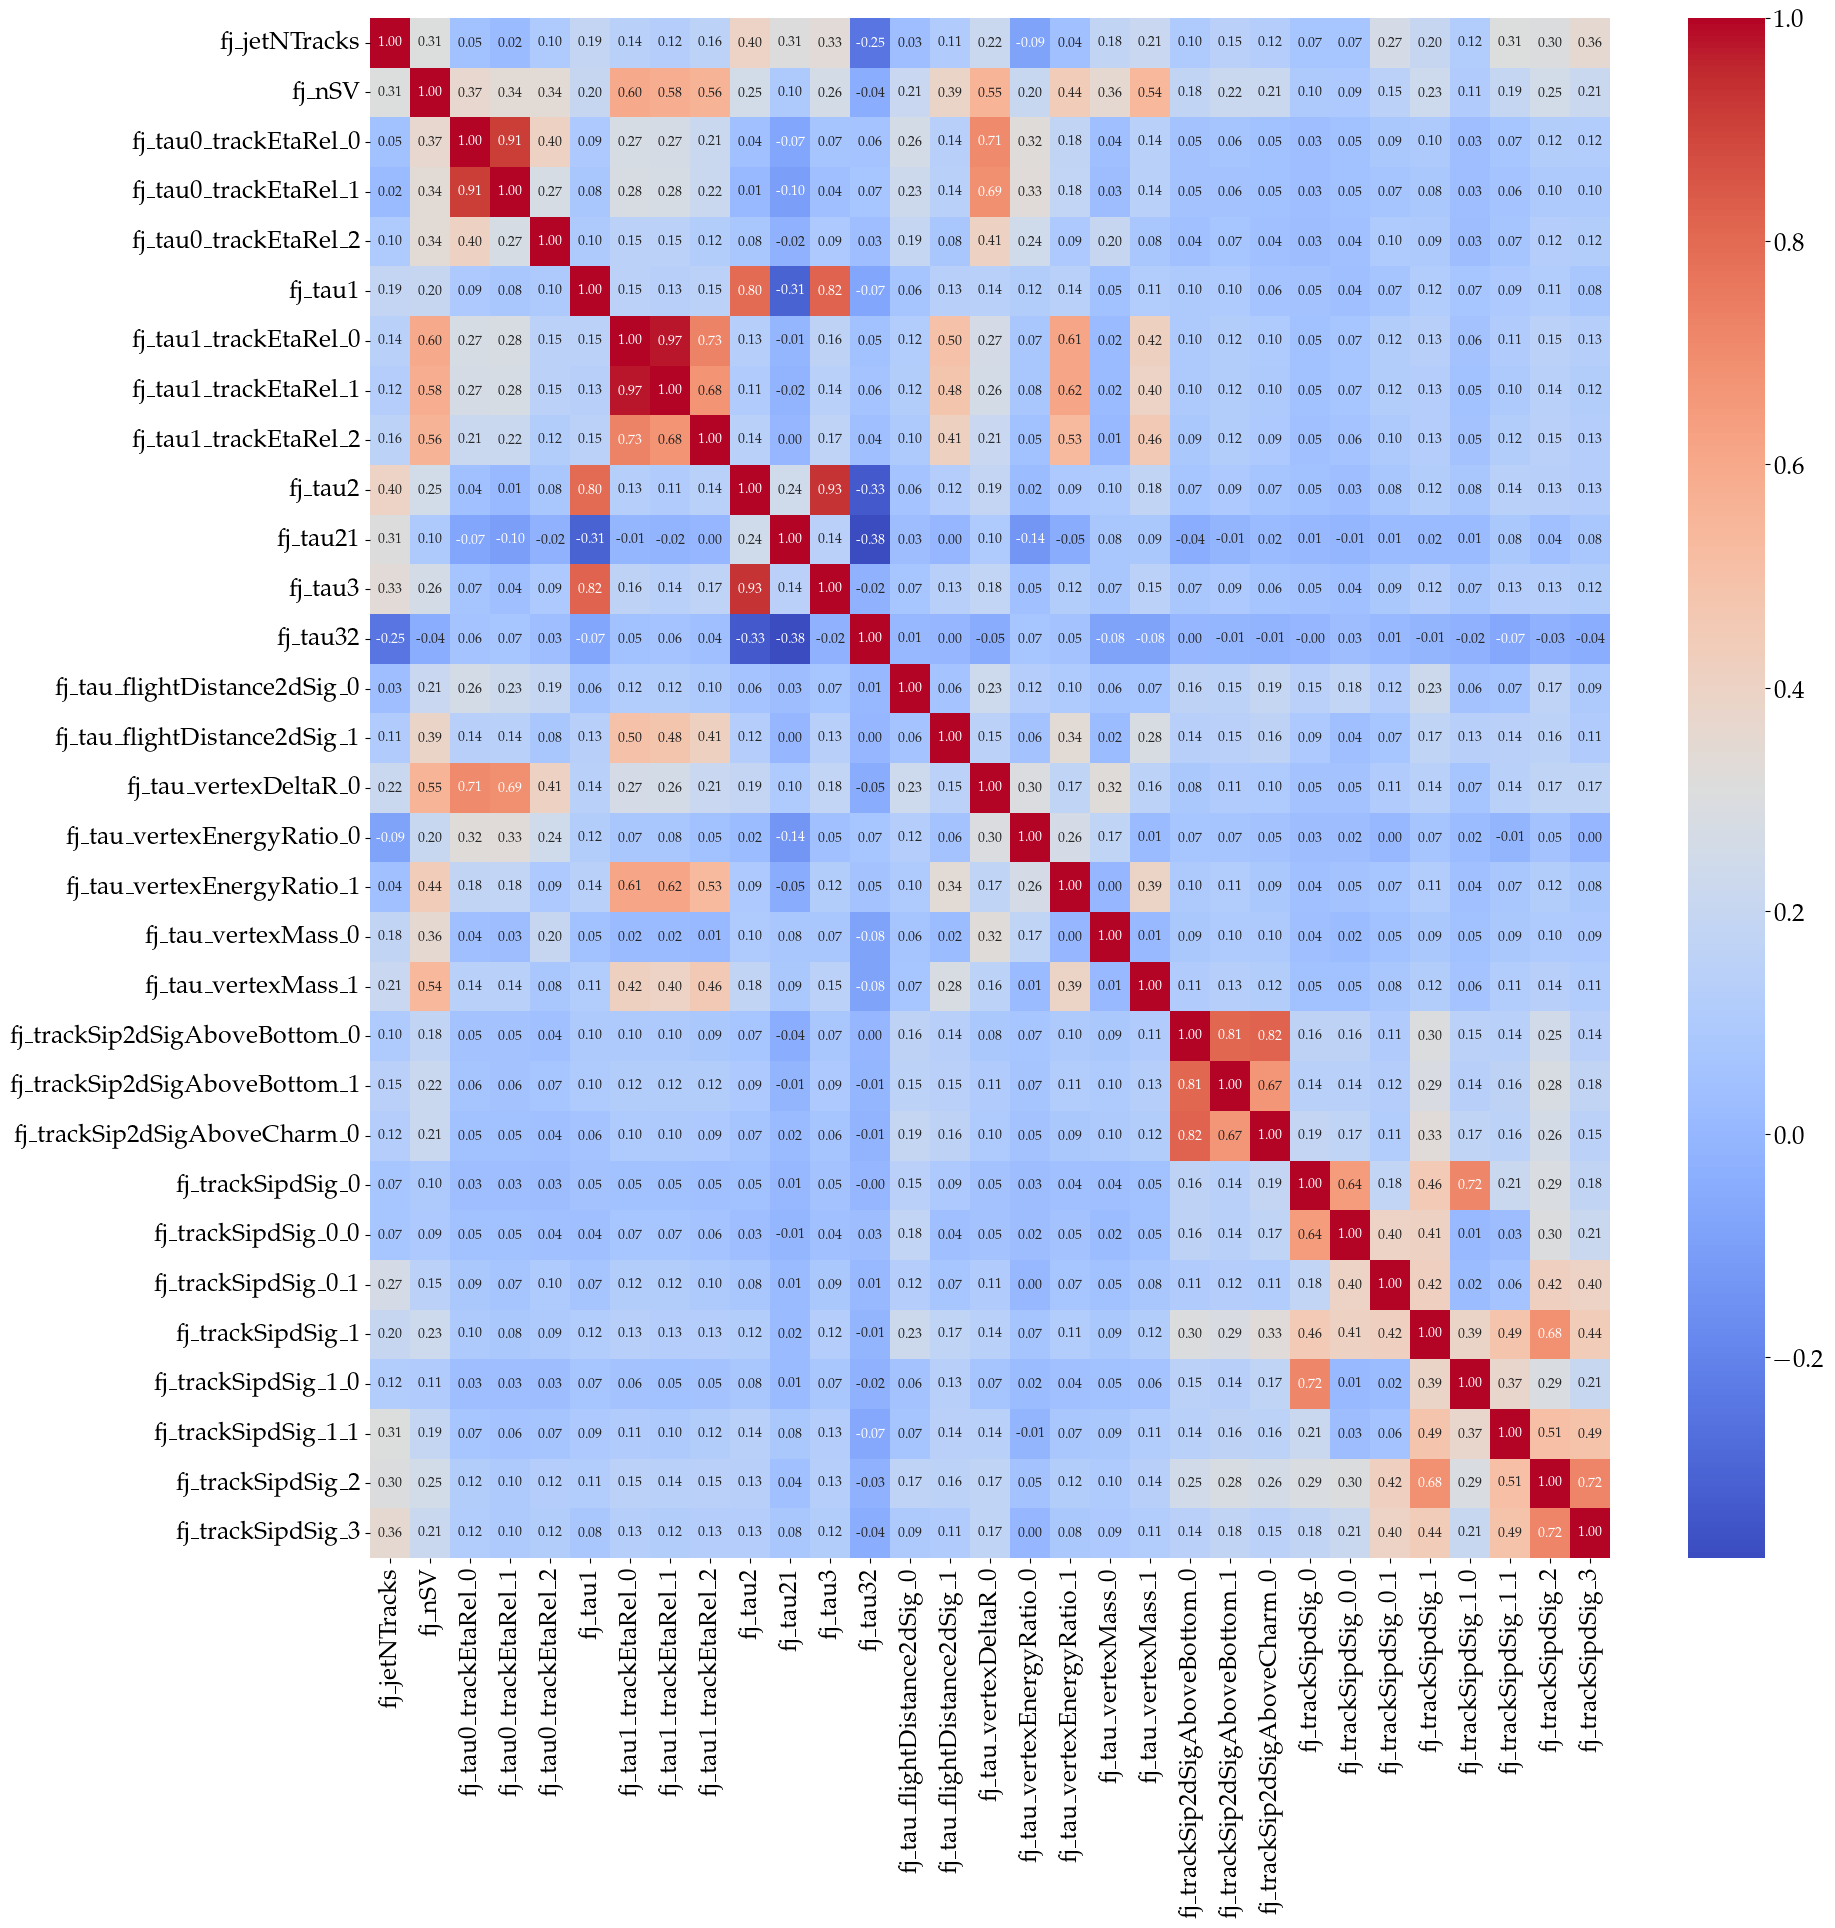

In [17]:
plt.figure(figsize=(20,20))
sns.heatmap(sig_train_out.corr(), cmap='coolwarm',annot=True, fmt='.2f')
plt.show()

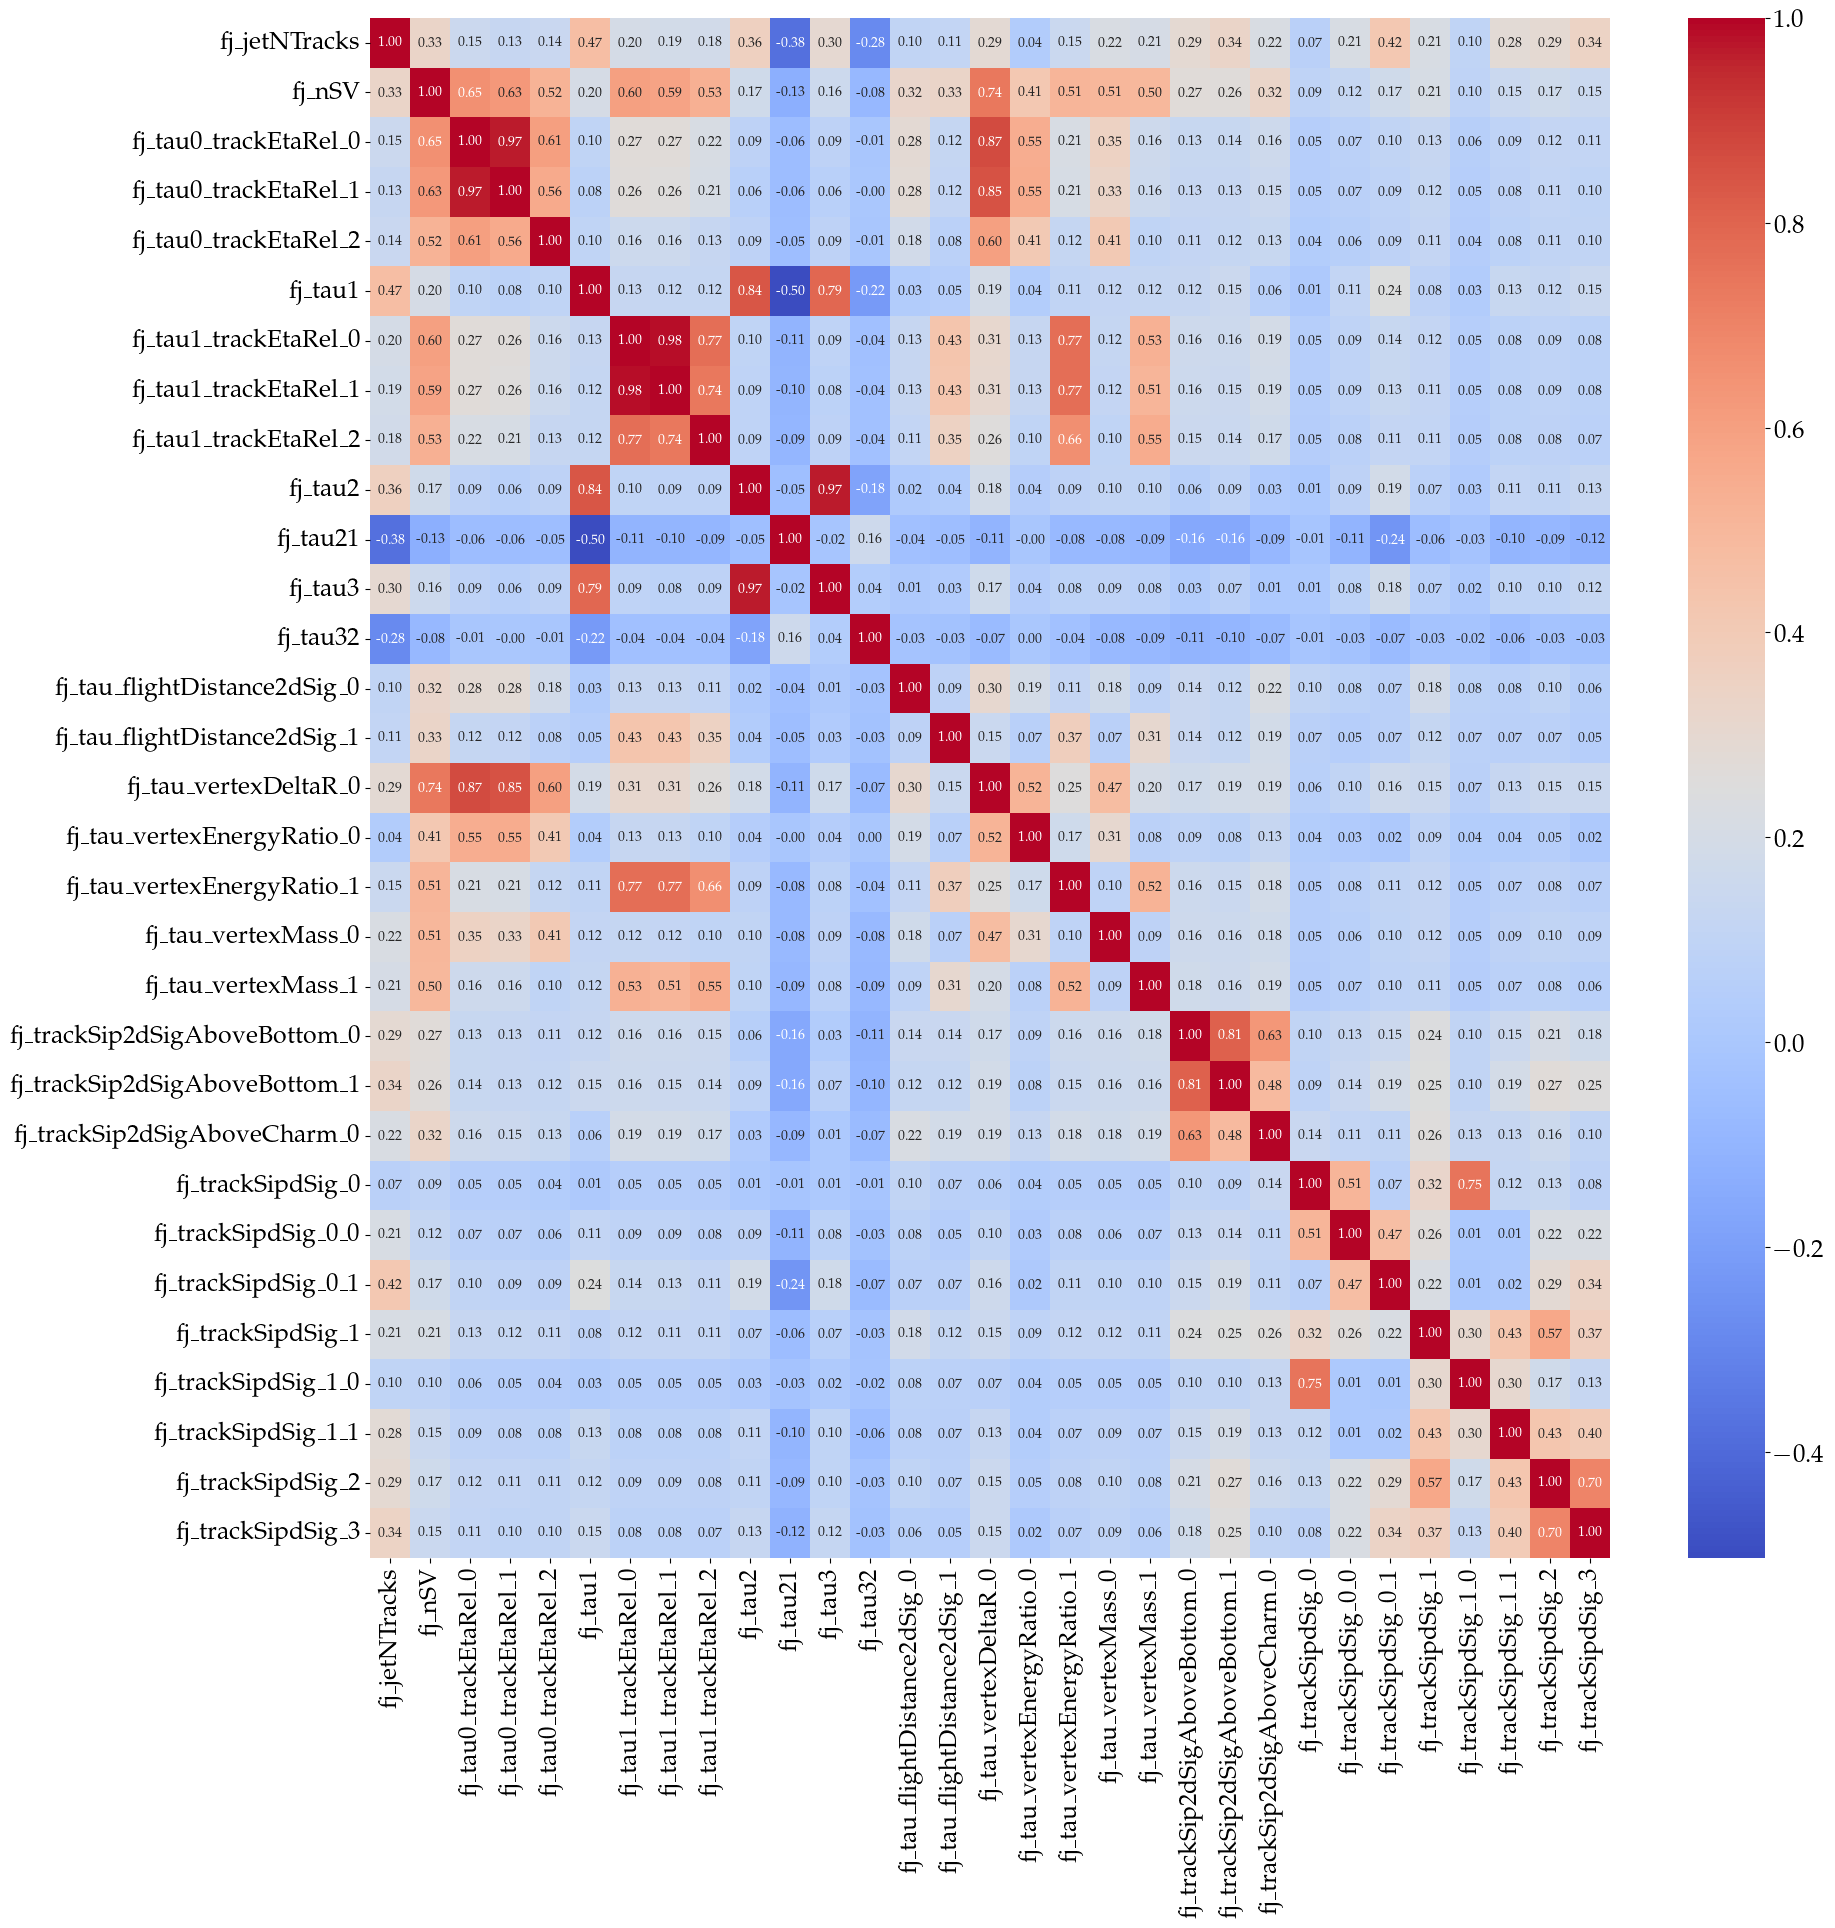

In [18]:
plt.figure(figsize=(20,20))
sns.heatmap(bkg_train_out.corr(), cmap='coolwarm',annot=True, fmt='.2f')
plt.show()

In [19]:
hbb = np.concatenate((np.ones(len(sig_train_out)),np.zeros(len(bkg_train_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_train_out)),np.ones(len(bkg_train_out))), axis=None)
traindata = pd.concat([sig_train_out, bkg_train_out])
traindata['hbb'] = hbb
traindata['QCD'] = QCD

train = traindata.sample(frac=1).reset_index(drop=True)
X_train = train.iloc[:,:-2]
y_train = train.iloc[:,-2:]

In [20]:
del traindata

In [21]:
hbb = np.concatenate((np.ones(len(sig_test_out)),np.zeros(len(bkg_test_out))), axis=None)
QCD = np.concatenate((np.zeros(len(sig_test_out)),np.ones(len(bkg_test_out))), axis=None)
testdata = pd.concat([sig_test_out, bkg_test_out])
testdata['hbb'] = hbb
testdata['QCD'] = QCD

test = testdata.sample(frac=1).reset_index(drop=True)
X_test = test.iloc[:,:-2]
y_test = test.iloc[:,-2:]

In [22]:
del testdata

In [23]:
%%time
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)

CPU times: user 376 ms, sys: 180 ms, total: 556 ms
Wall time: 555 ms


In [24]:
eigenvalues, eigenvectors = np.linalg.eig(X_train.cov())

In [25]:
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

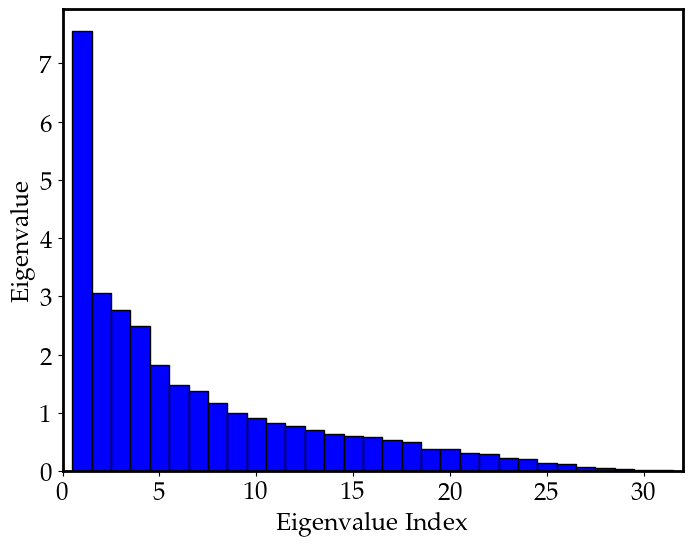

In [27]:
plt.figure(figsize=(8,6))
x = np.arange(1,nfeatures+1)
plt.xlim(0,nfeatures+1)
plt.bar(x,eigenvalues,color='b',width=1,edgecolor='k')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.show()

In [28]:
%%time
pca = PCA()
pca.fit(X_train)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))
print(pca.singular_values_)

[0.2437171  0.09875358 0.08929716 0.08006593 0.05858738 0.04741118
 0.04430546 0.03768359 0.03219142 0.02951176 0.02660632 0.0248346
 0.02266295 0.020275   0.019569   0.01892981 0.01730528 0.01596466
 0.01240985 0.01193716 0.01019994 0.0096963  0.00705042 0.0066685
 0.00459254 0.00383503 0.00213784 0.00142983 0.0013966  0.00058391
 0.0003899 ]
[0.2437171  0.34247068 0.43176784 0.51183377 0.57042115 0.61783233
 0.66213779 0.69982138 0.7320128  0.76152456 0.78813088 0.81296549
 0.83562843 0.85590343 0.87547243 0.89440224 0.91170752 0.92767218
 0.94008203 0.95201918 0.96221913 0.97191543 0.97896585 0.98563435
 0.99022689 0.99406192 0.99619975 0.99762958 0.99902618 0.9996101
 1.        ]
[5190.43696217 3303.97948362 3141.80882823 2974.98503594 2544.85446674
 2289.29260737 2213.04146854 2040.97208294 1886.38786087 1806.16938359
 1714.95734894 1656.87424122 1582.77479199 1497.06731047 1470.77160914
 1446.5520106  1383.08916826 1328.43634233 1171.23530675 1148.71259909
 1061.84176402 1035.294

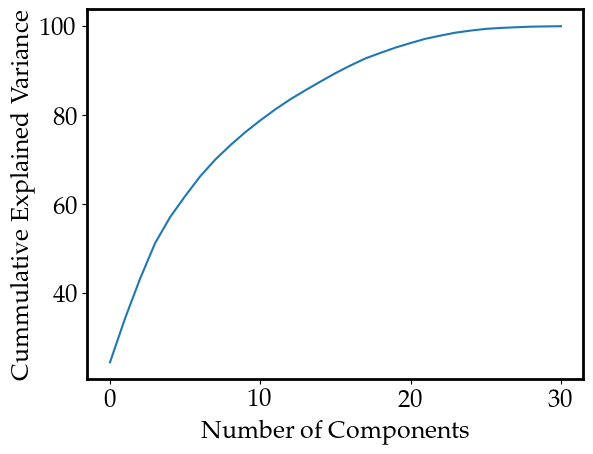

In [29]:
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('Number of Components')
plt.ylabel('Cummulative Explained Variance')
plt.show()

In [30]:
def KL(feature1 ,feature2 , bins = 100, eps = 1e-8):
    low, high = (np.min([np.min(feature1),np.min(feature2)]), np.max([np.max(feature1),np.max(feature2)]))
    pk, bins = np.histogram(feature1, bins=bins, range=(low,high))
    qk, bins = np.histogram(feature2, bins=bins, range=(low,high))
    pk = pk + eps
    qk = qk + eps
    D1 = stats.entropy(pk, qk)
    D2 = stats.entropy(qk, pk)
    divergence = D1 + D2
    return divergence

In [31]:
div = []
for i in tqdm(features):
    divergence = KL(sig_train_out[i], bkg_train_out[i])
    div.append(divergence)
divergences = pd.Series(div, index=features).sort_values(ascending=False)
print(divergences)

  0%|          | 0/31 [00:00<?, ?it/s]

fj_tau21                         2.226322
fj_trackSip2dSigAboveBottom_0    1.396349
fj_trackSip2dSigAboveCharm_0     1.172474
fj_trackSip2dSigAboveBottom_1    1.072229
fj_tau_flightDistance2dSig_0     0.925847
fj_trackSipdSig_0                0.912873
fj_tau_vertexEnergyRatio_0       0.756913
fj_trackSipdSig_0_0              0.708210
fj_nSV                           0.703856
fj_trackSipdSig_2                0.610316
fj_tau_vertexDeltaR_0            0.600450
fj_trackSipdSig_0_1              0.598732
fj_tau_vertexEnergyRatio_1       0.597167
fj_trackSipdSig_1                0.587591
fj_tau1                          0.558210
fj_tau0_trackEtaRel_1            0.489708
fj_tau0_trackEtaRel_0            0.489295
fj_tau_flightDistance2dSig_1     0.451174
fj_tau1_trackEtaRel_1            0.440124
fj_tau1_trackEtaRel_0            0.438557
fj_trackSipdSig_3                0.396070
fj_trackSipdSig_1_0              0.344042
fj_tau1_trackEtaRel_2            0.312891
fj_tau0_trackEtaRel_2            0

In [32]:
# X_train_final = pd.DataFrame(pca.transform(X_train)).iloc[:,:20]
# X_test_final =  pd.DataFrame(pca.transform(X_test)).iloc[:,:20]
X_train_final = X_train
X_test_final =  X_test

In [36]:
def make_ks_plot(y_train, train_proba, y_test, test_proba, bins=30, fig_sz=(10, 8)):
    '''
    OUTPUT: outputs KS test/train overtraining plots for classifier output
    INPUTS:
        y_train - Series with outputs of model
        train_proba - np.ndarray from sklearn predict_proba(). Same shape as y_train. 0-1 probabilities from model.
        y_test - Series with outputs of model
        test_proba - np.ndarray from sklearn predict_proba(). Same shape as y_test. 0-1 probabilities from model.
        bins - number of bins for viz. Default 30.
        fig_sz - change to True in order to get larger outputs. Default False.
    '''

    train = pd.DataFrame(y_train, columns=["label"])
    test = pd.DataFrame(y_test, columns=["label"])
    train["probability"] = train_proba
    test["probability"] = test_proba
    
    decisions = []
    for df in [train, test]:
        d1 = df['probability'][df["label"] == 1]
        d2 = df['probability'][df["label"] == 0]
        decisions += [d1, d2]

    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (0,1)

    fig = plt.figure(figsize=fig_sz)
    
    train_pos = plt.hist(decisions[0],
         color='b', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Signal (test)')

    train_neg = plt.hist(decisions[1],
         color='r', alpha=0.5, range=low_high, bins=bins,
         histtype='stepfilled', density=True,
         label='Background (test)')

    hist, bins = np.histogram(decisions[2],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    test_pos = plt.errorbar(center, hist, yerr=err, fmt='o', c='b', label='Signal (train)')

    hist, bins = np.histogram(decisions[3],
                          bins=bins, range=low_high, density=True)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    test_neg = plt.errorbar(center, hist, yerr=err, fmt='o', c='r', label='Background (train)')

    # get the KS score
    ks = stats.ks_2samp(decisions[0], decisions[2])

    plt.xlabel("Classifier Output", fontsize=12)
    plt.ylabel("Arbitrary Normalized Units", fontsize=12)

    plt.xlim(0, 1)
    plt.plot([], [], ' ', label='KS Statistic (p-value): '+str(round(ks[0],3))+' ('+str(round(ks[1],3))+')')
    plt.legend(loc='upper center', fontsize=12)
    plt.tight_layout()
    plt.close()
    return fig

In [37]:
# build a simple neural network in keras

keras_model = keras.Sequential()
keras_model.add(Dense(units=60,activation='relu',input_dim=X_train_final.shape[1]))
keras_model.add(Dense(units=60,activation='relu'))
keras_model.add(Dense(units=2,activation='softmax'))
keras_model.save_weights('random_weights.h5')
print(keras_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                1920      
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dense_2 (Dense)             (None, 2)                 122       
                                                                 
Total params: 5,702
Trainable params: 5,702
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
losses = []
rates = np.logspace(-3,0,100)

for lr in tqdm(rates):
    keras_model.load_weights('random_weights.h5')
    opt = keras.optimizers.SGD(learning_rate=lr)
    keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    history = keras_model.fit(X_train_final.to_numpy(), y_train.to_numpy(), batch_size=2**14, epochs=10,
                              shuffle=False)
    losses.append(history.history['loss'][-1])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/10
  1/218 [..............................] - ETA: 30s - loss: 0.6599 - accuracy: 0.6105

2022-11-04 22:19:58.256572: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


218/218 [==============================] - 1s 4ms/step - loss: 0.6029 - accuracy: 0.6976
Epoch 2/10
218/218 [==============================] - 1s 5ms/step - loss: 0.5462 - accuracy: 0.7571
Epoch 3/10
218/218 [==============================] - 1s 5ms/step - loss: 0.5172 - accuracy: 0.7710
Epoch 4/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4966 - accuracy: 0.7792
Epoch 5/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4804 - accuracy: 0.7856
Epoch 6/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4671 - accuracy: 0.7912
Epoch 7/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4558 - accuracy: 0.7962
Epoch 8/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4459 - accuracy: 0.8009
Epoch 9/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4371 - accuracy: 0.8055
Epoch 10/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4292 - accuracy: 0.8099
Epoch 1/10

Epoch 3/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4826 - accuracy: 0.7847
Epoch 4/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4601 - accuracy: 0.7943
Epoch 5/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4427 - accuracy: 0.8026
Epoch 6/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4285 - accuracy: 0.8103
Epoch 7/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4165 - accuracy: 0.8171
Epoch 8/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4062 - accuracy: 0.8229
Epoch 9/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3973 - accuracy: 0.8278
Epoch 10/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3897 - accuracy: 0.8318
Epoch 1/10
218/218 [==============================] - 1s 4ms/step - loss: 0.5776 - accuracy: 0.7246
Epoch 2/10
218/218 [==============================] - 1s 5ms/step - loss: 0.5109 - accuracy: 0.7734

218/218 [==============================] - 1s 5ms/step - loss: 0.4210 - accuracy: 0.8145
Epoch 5/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4029 - accuracy: 0.8247
Epoch 6/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3890 - accuracy: 0.8322
Epoch 7/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3780 - accuracy: 0.8375
Epoch 8/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3694 - accuracy: 0.8415
Epoch 9/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3625 - accuracy: 0.8447
Epoch 10/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3568 - accuracy: 0.8472
Epoch 1/10
218/218 [==============================] - 1s 5ms/step - loss: 0.5513 - accuracy: 0.7446
Epoch 2/10
218/218 [==============================] - 1s 4ms/step - loss: 0.4757 - accuracy: 0.7876
Epoch 3/10
218/218 [==============================] - 1s 4ms/step - loss: 0.4402 - accuracy: 0.8040
Epoch 4/10

Epoch 6/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3563 - accuracy: 0.8474
Epoch 7/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3486 - accuracy: 0.8509
Epoch 8/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3424 - accuracy: 0.8536
Epoch 9/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3373 - accuracy: 0.8559
Epoch 10/10
218/218 [==============================] - 1s 4ms/step - loss: 0.3329 - accuracy: 0.8580
Epoch 1/10
218/218 [==============================] - 1s 4ms/step - loss: 0.5214 - accuracy: 0.7620
Epoch 2/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4377 - accuracy: 0.8055
Epoch 3/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4005 - accuracy: 0.8260
Epoch 4/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3777 - accuracy: 0.8376
Epoch 5/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3631 - accuracy: 0.8444

218/218 [==============================] - 1s 5ms/step - loss: 0.3259 - accuracy: 0.8611
Epoch 8/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3202 - accuracy: 0.8636
Epoch 9/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3152 - accuracy: 0.8660
Epoch 10/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3106 - accuracy: 0.8682
Epoch 1/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4883 - accuracy: 0.7790
Epoch 2/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3983 - accuracy: 0.8271
Epoch 3/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3651 - accuracy: 0.8434
Epoch 4/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3483 - accuracy: 0.8510
Epoch 5/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3377 - accuracy: 0.8557
Epoch 6/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3297 - accuracy: 0.8594
Epoch 7/10

Epoch 9/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2918 - accuracy: 0.8773
Epoch 10/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2873 - accuracy: 0.8794
Epoch 1/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4524 - accuracy: 0.7981
Epoch 2/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3637 - accuracy: 0.8441
Epoch 3/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3392 - accuracy: 0.8551
Epoch 4/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3257 - accuracy: 0.8612
Epoch 5/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3156 - accuracy: 0.8658
Epoch 6/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3073 - accuracy: 0.8698
Epoch 7/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3002 - accuracy: 0.8733
Epoch 8/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2941 - accuracy: 0.8761

218/218 [==============================] - 1s 5ms/step - loss: 0.2712 - accuracy: 0.8871
Epoch 1/10
218/218 [==============================] - 1s 5ms/step - loss: 0.4165 - accuracy: 0.8168
Epoch 2/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3379 - accuracy: 0.8557
Epoch 3/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3170 - accuracy: 0.8652
Epoch 4/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3029 - accuracy: 0.8720
Epoch 5/10
218/218 [==============================] - 1s 6ms/step - loss: 0.2922 - accuracy: 0.8770
Epoch 6/10
218/218 [==============================] - 1s 6ms/step - loss: 0.2844 - accuracy: 0.8808
Epoch 7/10
218/218 [==============================] - 1s 6ms/step - loss: 0.2788 - accuracy: 0.8835
Epoch 8/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2749 - accuracy: 0.8853
Epoch 9/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2721 - accuracy: 0.8867
Epoch 10/10

218/218 [==============================] - 1s 4ms/step - loss: 0.3846 - accuracy: 0.8325
Epoch 2/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3156 - accuracy: 0.8658
Epoch 3/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2938 - accuracy: 0.8763
Epoch 4/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2809 - accuracy: 0.8824
Epoch 5/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2739 - accuracy: 0.8858
Epoch 6/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2697 - accuracy: 0.8878
Epoch 7/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2666 - accuracy: 0.8893
Epoch 8/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2642 - accuracy: 0.8906
Epoch 9/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2621 - accuracy: 0.8916
Epoch 10/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2603 - accuracy: 0.8925
Epoch 1/10

Epoch 3/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2749 - accuracy: 0.8853
Epoch 4/10
218/218 [==============================] - 1s 4ms/step - loss: 0.2678 - accuracy: 0.8888
Epoch 5/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2635 - accuracy: 0.8909
Epoch 6/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2602 - accuracy: 0.8925
Epoch 7/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2575 - accuracy: 0.8938
Epoch 8/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2551 - accuracy: 0.8949
Epoch 9/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2531 - accuracy: 0.8958
Epoch 10/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2514 - accuracy: 0.8967
Epoch 1/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3535 - accuracy: 0.8477
Epoch 2/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2899 - accuracy: 0.8781

218/218 [==============================] - 1s 5ms/step - loss: 0.2586 - accuracy: 0.8932
Epoch 5/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2545 - accuracy: 0.8952
Epoch 6/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2513 - accuracy: 0.8967
Epoch 7/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2488 - accuracy: 0.8979
Epoch 8/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2468 - accuracy: 0.8988
Epoch 9/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2453 - accuracy: 0.8994
Epoch 10/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2440 - accuracy: 0.9001
Epoch 1/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3282 - accuracy: 0.8596
Epoch 2/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2730 - accuracy: 0.8863
Epoch 3/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2630 - accuracy: 0.8911
Epoch 4/10

Epoch 6/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2457 - accuracy: 0.8991
Epoch 7/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2440 - accuracy: 0.8999
Epoch 8/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2426 - accuracy: 0.9006
Epoch 9/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2414 - accuracy: 0.9011
Epoch 10/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2403 - accuracy: 0.9016
Epoch 1/10
218/218 [==============================] - 1s 5ms/step - loss: 0.3062 - accuracy: 0.8699
Epoch 2/10
218/218 [==============================] - 1s 4ms/step - loss: 0.2631 - accuracy: 0.8911
Epoch 3/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2555 - accuracy: 0.8947
Epoch 4/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2508 - accuracy: 0.8968
Epoch 5/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2476 - accuracy: 0.8983

218/218 [==============================] - 1s 5ms/step - loss: 0.2400 - accuracy: 0.9016
Epoch 8/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2390 - accuracy: 0.9021
Epoch 9/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2380 - accuracy: 0.9025
Epoch 10/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2373 - accuracy: 0.9029
Epoch 1/10
218/218 [==============================] - 3s 4ms/step - loss: 0.2970 - accuracy: 0.8738
Epoch 2/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2580 - accuracy: 0.8933
Epoch 3/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2500 - accuracy: 0.8971
Epoch 4/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2454 - accuracy: 0.8992
Epoch 5/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2427 - accuracy: 0.9005
Epoch 6/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2409 - accuracy: 0.9012
Epoch 7/10

Epoch 9/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2354 - accuracy: 0.9037
Epoch 10/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2346 - accuracy: 0.9040
Epoch 1/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2936 - accuracy: 0.8759
Epoch 2/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2536 - accuracy: 0.8953
Epoch 3/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2461 - accuracy: 0.8988
Epoch 4/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2423 - accuracy: 0.9005
Epoch 5/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2399 - accuracy: 0.9016
Epoch 6/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2380 - accuracy: 0.9025
Epoch 7/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2369 - accuracy: 0.9030
Epoch 8/10
218/218 [==============================] - 1s 5ms/step - loss: 0.2359 - accuracy: 0.9034

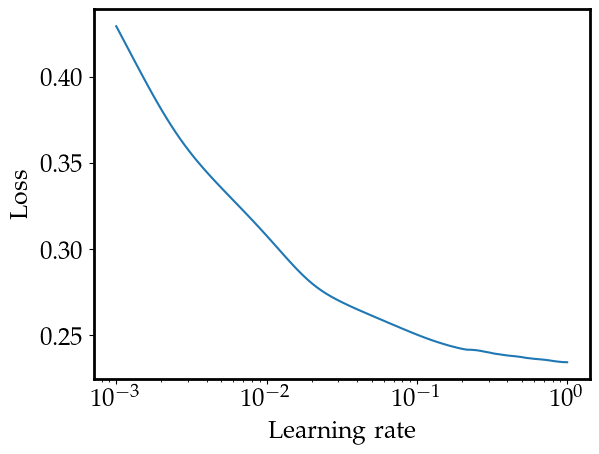

In [39]:
plt.plot(rates, losses)
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.semilogx()
plt.show()

In [40]:
lr = rates[np.nanargmin(losses)]
print(lr)

1.0


In [41]:
%%time
# fit keras model
keras_model.load_weights('random_weights.h5')
opt = keras.optimizers.SGD(learning_rate=lr)
keras_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = keras_model.fit(X_train_final.to_numpy(), y_train.to_numpy(), batch_size=2**14, 
                          epochs=100)

Epoch 1/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2941 - accuracy: 0.8756
Epoch 2/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2530 - accuracy: 0.8955
Epoch 3/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2457 - accuracy: 0.8989
Epoch 4/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2419 - accuracy: 0.9007
Epoch 5/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2396 - accuracy: 0.9016
Epoch 6/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2380 - accuracy: 0.9025
Epoch 7/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2365 - accuracy: 0.9031
Epoch 8/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2357 - accuracy: 0.9035
Epoch 9/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2349 - accuracy: 0.9038
Epoch 10/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2343 - accura

218/218 [==============================] - 1s 5ms/step - loss: 0.2197 - accuracy: 0.9109
Epoch 82/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2196 - accuracy: 0.9110
Epoch 83/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2200 - accuracy: 0.9108
Epoch 84/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2194 - accuracy: 0.9111
Epoch 85/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2197 - accuracy: 0.9109
Epoch 86/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2198 - accuracy: 0.9109
Epoch 87/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2196 - accuracy: 0.9111
Epoch 88/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2193 - accuracy: 0.9112
Epoch 89/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2193 - accuracy: 0.9112
Epoch 90/100
218/218 [==============================] - 1s 5ms/step - loss: 0.2194 - accuracy: 

In [42]:
# run model inference on test data set
predict_array_train = keras_model.predict(X_train_final)
predict_array_test = keras_model.predict(X_test_final)

13921/13921 [==============================] - 4s 303us/step


In [43]:
# create ROC curve
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,0])

In [44]:
print(keras_model.evaluate(X_train_final,y_train))
print(keras_model.evaluate(X_test_final,y_test))

111433/111433 [==============================] - 33s 291us/step - loss: 0.2174 - accuracy: 0.9120
[0.21742747724056244, 0.9119769334793091]
13921/13921 [==============================] - 4s 299us/step - loss: 0.2195 - accuracy: 0.9112
[0.2195201814174652, 0.9112430810928345]


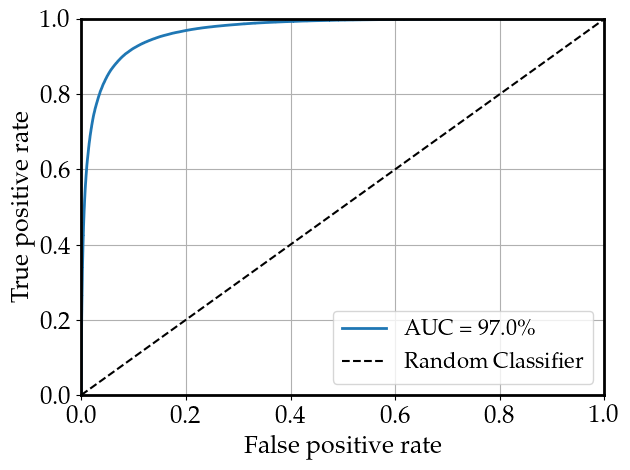

In [45]:
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_MLP_subjettiness_and_impact_parameter.pdf')
plt.show()

In [46]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,0],
                   y_test.to_numpy()[:,0], predict_array_test[:,0])
fig.savefig('plots/KS_MLP_subjettiness_and_impact_parameter.pdf')

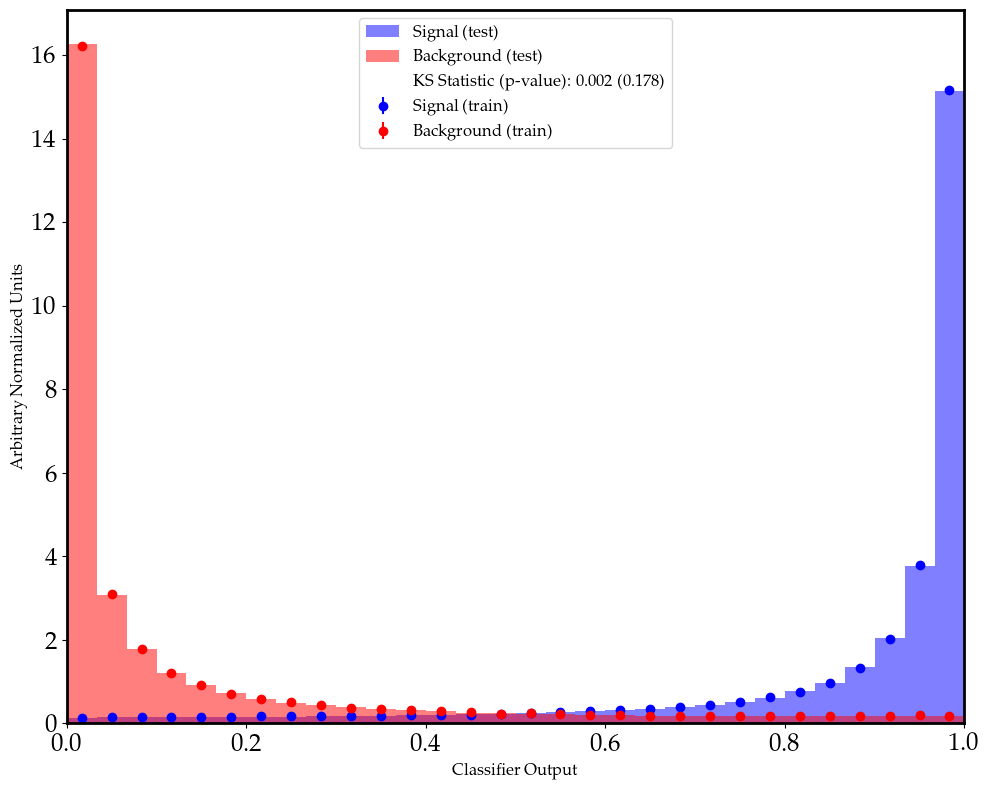

In [47]:
fig

In [54]:
bdt = XGBClassifier(booster='gbtree')

In [55]:
%%time
bdt.fit(X_train_final.to_numpy(), y_train.to_numpy())

CPU times: user 1h 6min 31s, sys: 1min 33s, total: 1h 8min 5s
Wall time: 7min 41s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [56]:
print(bdt.score(X_train_final.to_numpy(), y_train.to_numpy()))
print(bdt.score(X_test_final.to_numpy(), y_test.to_numpy()))

0.9118538032983101
0.9095347772210549


In [57]:
predict_array_train = bdt.predict_proba(X_train_final)
predict_array_test = bdt.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,0])

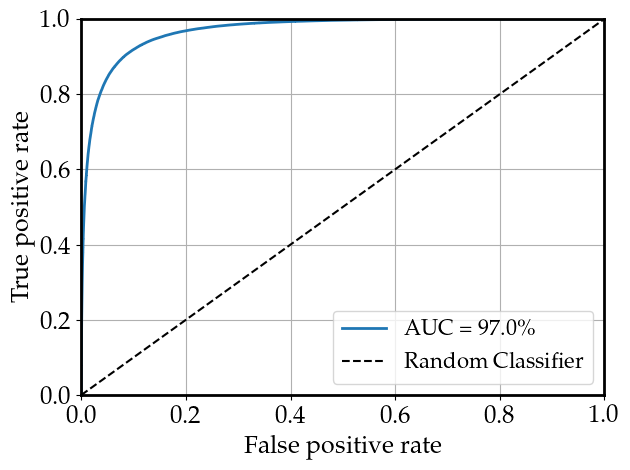

In [58]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_BDT_subjettiness_and_impact_parameter.pdf')
plt.show()

In [59]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,0],
                   y_test.to_numpy()[:,0], predict_array_test[:,0])
fig.savefig('plots/KS_BDT_subjettiness_and_impact_parameter.pdf')

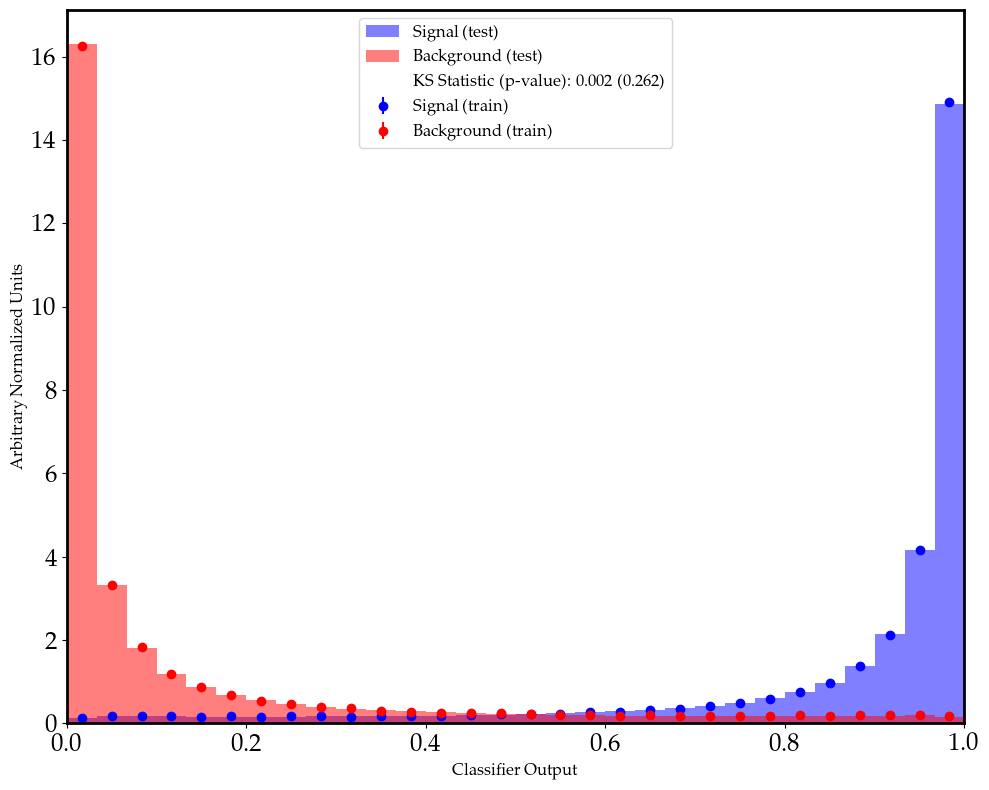

In [60]:
fig

In [61]:
fisher = LinearDiscriminantAnalysis()

In [63]:
%%time
fisher.fit(X_train_final.to_numpy(), y_train.to_numpy()[:,0])

CPU times: user 12.7 s, sys: 2.2 s, total: 14.9 s
Wall time: 7.39 s


LinearDiscriminantAnalysis()

In [64]:
print(fisher.score(X_train_final.to_numpy(), y_train.to_numpy()[:,0]))
print(fisher.score(X_test_final.to_numpy(), y_test.to_numpy()[:,0]))

0.8500563403822845
0.8512090763787871


In [65]:
predict_array_train = fisher.predict_proba(X_train_final)
predict_array_test = fisher.predict_proba(X_test_final)
fpr, tpr, threshold = roc_curve(y_test.to_numpy()[:,0], predict_array_test[:,1])

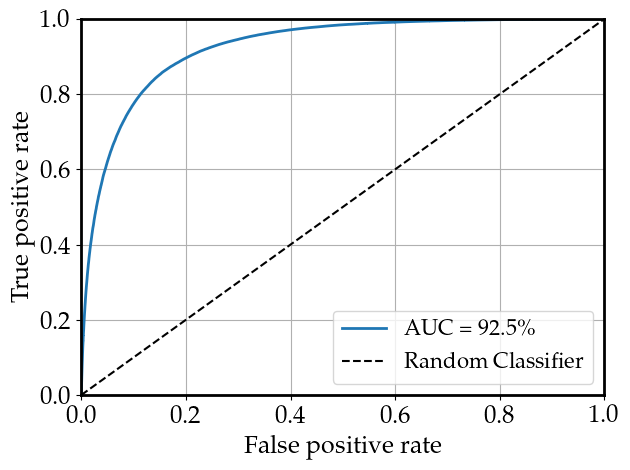

In [66]:
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"AUC = {auc(fpr,tpr)*100:.1f}\%")
plt.plot(np.linspace(0,1),np.linspace(0,1),color='k',ls='--',label = 'Random Classifier')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('plots/ROC_LDA_subjettiness_and_impact_parameter.pdf')
plt.show()

In [67]:
fig = make_ks_plot(y_train.to_numpy()[:,0], predict_array_train[:,1],
                   y_test.to_numpy()[:,0], predict_array_test[:,1])
fig.savefig('plots/KS_LDA_subjettiness_and_impact_parameter.pdf')

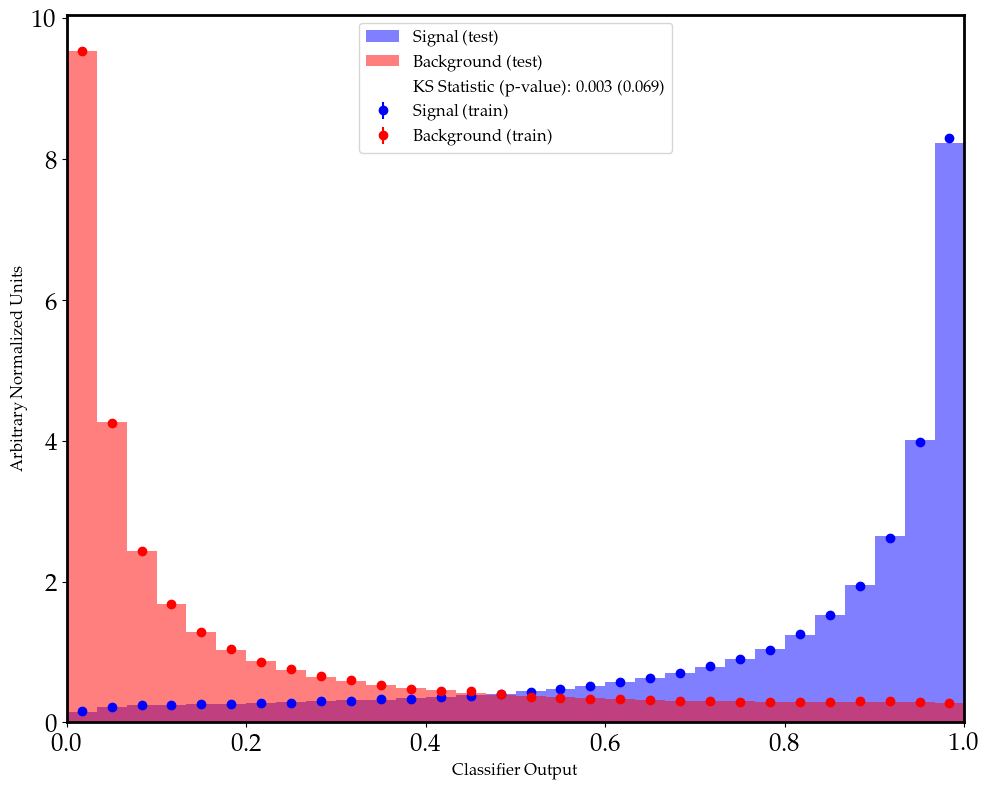

In [68]:
fig